### Define all functions

In [1]:
import cv2
import csv
import numpy as np
import os

In [2]:
def getCSVRows(dataPath, skipHeader=False):
    """
    Returns the rows from a driving log with base directory `dataPath`.
    If the file include headers, pass `skipHeader=True`.
    """
    lines = []
    with open(dataPath + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        if skipHeader:
            next(reader, None)
        for line in reader:
            lines.append(line)
    return lines

In [3]:
def findImages(dataPath):
    """
    Finds all the images needed for training on the path `dataPath`.
    Returns `([centerPaths], [leftPath], [rightPath], [measurements])`
    """
    imgPath = dataPath + 'IMG/'
    lines = getCSVRows(dataPath)
    centerPaths = []
    leftPath = []
    rightPath = []
    measurements = []
    for line in lines:
        try:
            measurements.append(float(line[3]))
            centerPaths.append(imgPath + line[0].split('\\')[-1])
            leftPath.append(imgPath + line[1].split('\\')[-1])
            rightPath.append(imgPath + line[2].split('\\')[-1])
        except:
            print("CSV may contain null")
    return (centerPaths, leftPath, rightPath, measurements)

In [4]:
def applyAngleCorrection(centerPath, leftPath, rightPath, measurements, angle_correction=0.2):
    """
    Combine the image paths from `centerPath`, `leftPath` and `rightPath` using the correction factor `angle_correction`
    Returns ([imagePaths], [mod_measurements])
    """
    imagePaths = []
    imagePaths.extend(centerPath)
    imagePaths.extend(leftPath)
    imagePaths.extend(rightPath)
    mod_measurements = []
    mod_measurements.extend(measurements)
    mod_measurements.extend([x + angle_correction for x in measurements])
    mod_measurements.extend([x - angle_correction for x in measurements])
    return (imagePaths, mod_measurements)

In [5]:
import sklearn

def generator(samples, batch_size=128):
    """
    Generate the required images and measurments for training/
    `samples` is a list of pairs (`imagePath`, `measurement`).
    """
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for imagePath, measurement in batch_samples:
                originalImage = cv2.imread(imagePath)
                image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
                images.append(image)
                angles.append(measurement)
                
                # Augment image by flipping
                images.append(cv2.flip(image,1))
                angles.append(-measurement)

            # trim image to only see section with road
            inputs = np.array(images)
            outputs = np.array(angles)
            shuffled = sklearn.utils.shuffle(inputs, outputs)
            yield shuffled[0], shuffled[1]

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Conv2D, AveragePooling2D, Dropout

def getModel():
    """
    Create model based on NVDIA Self Driving Cars model
    """
    model = Sequential()
    
    # Preprocess: Normalize and zero mean variance
    model.add(Lambda(lambda x: (x / 255.0) - 0.5421, input_shape=(160,320,3)))
    
    # Trim image to see road section
    model.add(Cropping2D(cropping=((60,20), (0,0))))
    
    # Modified NVIDIA Self Driving Cars Model
    model.add(Conv2D(filters=3, kernel_size=(5,5), strides=(1, 2), padding="valid", activation="relu"))
    model.add(Conv2D(filters=24, kernel_size=(5,5), strides=(1, 2), padding="valid", activation="relu"))
    model.add(Conv2D(filters=36, kernel_size=(5,5), strides=(2, 2), padding="valid", activation="relu"))
    model.add(Conv2D(filters=48, kernel_size=(5,5), strides=(2, 2), padding="valid", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding="valid", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(2, 2), padding="valid", activation="relu"))
    model.add(Flatten())
    model.add(Dense(1164))
    model.add(Dropout(0.5, seed=0))
    model.add(Dense(100))
    model.add(Dropout(0.5, seed=0))
    model.add(Dense(50))
    model.add(Dropout(0.5, seed=0))
    model.add(Dense(10))
    model.add(Dropout(0.5, seed=0))
    model.add(Dense(1))

    return model

### Reading Images

In [7]:
centerPaths, leftPaths, rightPaths, measurements = findImages('data/')
imagePaths, measurements = applyAngleCorrection(centerPaths, leftPaths, rightPaths, measurements, angle_correction=0.2)
print('Total Images: {}'.format(len(imagePaths)))
print('Total Measurements: {}'.format(len(measurements)))

Total Images: 93003
Total Measurements: 93003


### Split Images using Data Generator

In [8]:
BATCH_SIZE = 256

from sklearn.model_selection import train_test_split
samples = list(zip(imagePaths, measurements))
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

print('Train samples: {}'.format(len(train_samples)))
print('Validation samples: {}'.format(len(validation_samples)))

train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

Train samples: 74402
Validation samples: 18601


### Get Model Summary

In [9]:
model = getModel()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 76, 158, 3)        228       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 77, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 37, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 17, 48)        43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 8, 64)          2

### Train the model

In [16]:
from math import ceil, exp
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

# Set Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * exp(-0.1)

# Set checkpoint to save the best epoch
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
# Compiling and training the model
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, steps_per_epoch=ceil(len(train_samples)/BATCH_SIZE),
                 validation_data=validation_generator, validation_steps=ceil(len(validation_samples)/BATCH_SIZE), 
                 epochs=10, verbose=1, callbacks=[LearningRateScheduler(scheduler, verbose=1), model_checkpoint_callback])

model.save('model.h5')


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/10
291/291 [==============================] - 114s 393ms/step - loss: 0.0750 - val_loss: 0.0586

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/10
291/291 [==============================] - 122s 421ms/step - loss: 0.0703 - val_loss: 0.0580

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/10
291/291 [==============================] - 120s 411ms/step - loss: 0.0679 - val_loss: 0.0557

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/10
291/291 [==============================] - 119s 410ms/step - loss: 0.0662 - val_loss: 0.0527

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/10
291/291 [==============================] - 118s 405ms/step - loss: 0.0647 - val_loss: 0.0508

Epoch 00006: LearningRateScheduler reducing learning r

In [12]:
print(history_object.history.keys())
print('Loss')
print(history_object.history['loss'])
print('Validation Loss')
print(history_object.history['val_loss'])

dict_keys(['loss', 'val_loss', 'lr'])
Loss
[0.08789233863353729, 0.07260087132453918, 0.06897945702075958, 0.06630781292915344, 0.06424863636493683, 0.062436483800411224, 0.060920149087905884, 0.05862484499812126, 0.057122066617012024, 0.05556102842092514]
Validation Loss
[0.06089305132627487, 0.05756731331348419, 0.057618122547864914, 0.05321727693080902, 0.05425633117556572, 0.05679797753691673, 0.05297927185893059, 0.04908997565507889, 0.049666162580251694, 0.050953637808561325]


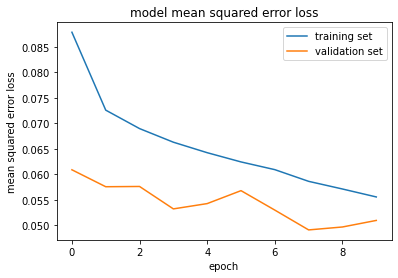

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

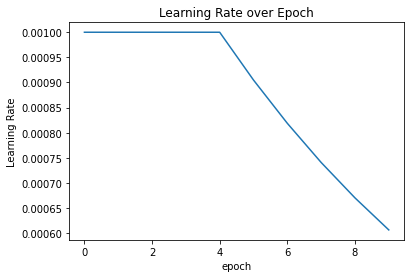

In [14]:
plt.plot(history_object.history['lr'])
plt.title('Learning Rate over Epoch')
plt.ylabel('Learning Rate')
plt.xlabel('epoch')
plt.show()